# Data visualization tools for PhysiCell

These scripts are meant to be used to read simulation results. The goal is to store the data from the simulation files in Python data structures to then plot the results. Three different strategies are implemented:

- Single time point
- Animation with several time points
    - Widget (visualize in the notebook)
- User interaction widget to select the time point to plot

In [10]:
from pathlib import Path

import numpy as np
# Basic visualization
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
# User interaction and online visualization
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import HTML

import physicool.processing as processing

## Data structures to store simulation data in Python

## Single timestep
This is the simplest type of visualization, as it consists of a single figure representing a specific time point of the simulation. We will be combining three heatmap plots, each corresponding to a substance present in the simulation. In addition, we will overlap circles on the heatmap to represent the cells. Thus, we will be able to visualize which areas have higher cellularity and how that relates to the distribution of the studied substances.

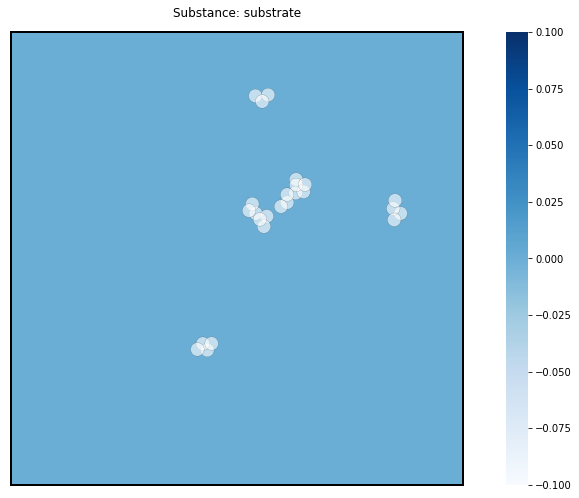

In [30]:
# Select the time point and the z-plane to visualize
time = 10
z_level = 0
cmap = 'Blues'
output_path = Path('../tests/PhysiCell/output/')

# Read data
me = processing.Microenvironment(time, output_path)

# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(12, 7))


# Plot the heatmap
sns.heatmap(me.data["substrate"][z_level],
            ax=ax,
            xticklabels=False, yticklabels=False,
            cmap=cmap,
            square=True)

# Get cell data to plot the cells' positions on top of the heatmap
variables = ['position_x', 'position_y', 'position_z']
cells = processing.Cells(time, output_path).positions


# Plot the cells as circles (the radius, R, is just placeholder value for now)
R = 0.75
circles = [plt.Circle((position[0], position[1]), radius=R)
           for position in positions]
col = PatchCollection(circles, edgecolor='black', facecolor="white", alpha=0.6, linewidth=0.2)
ax.add_collection(col)

# Figure style
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)

ax.set_title(f'Substance: {substance}', y=1.02)
ax.invert_yaxis()
    
plt.tight_layout()

## Animations
Animations are helpful to understand the evolution of our simulated system over time. For simplicity, we will only be plotting the heatmaps and not the cells, but this approach could be used to create the previous plot style as well.

### Animation widget
To see the animation online and be able to interact with it, we can use Jupyter widgets. This is a slightly different approach from before. We create two functions:
- `init()`, which is only run at the start of the simulation and that define the elements that will be kept constant over the animation (the colormap and colorbar)
- `my_func()`, which basically updates the existing heatmaps with the new values

In [42]:
%matplotlib inline
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

def init():
    """Initial function to plot the first time point data and define the constant elements."""
    me = processing.Microenvironment(0, output_path)
    sns.heatmap(me.data["substrate"][z_level],
        ax=ax,
        xticklabels=False, yticklabels=False,
        cmap=cmap,
        square=True)

def my_func(i):
    """Update function to plot new values into the heatmap."""
    me = processing.Microenvironment(i, output_path)
    sns.heatmap(me.data["substrate"][z_level],
            ax=ax,
            xticklabels=False, yticklabels=False,
            cmap=cmap,
            square=True,
            cbar=False)

# Create the animation using the previous function
anim = animation.FuncAnimation(fig=fig, func=my_func, init_func=init, 
                               frames=15, blit=False, repeat=False)

# Avoid duplicated results
plt.close()
# Visualize the animation
HTML(anim.to_jshtml())

## User selection
Lastly, going back to the approach where a single time point is represented, we can use a widget to allow users to select the time point and the z plane to visualize.

In [38]:
%matplotlib notebook

@interact(time=(0,10,1))
def plot_heatmaps(time=0):
    me = processing.Microenvironment(time, output_path)
    # Create a figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 7))


    # Plot the heatmap
    sns.heatmap(me.data["substrate"][z_level],
                ax=ax,
                xticklabels=False, yticklabels=False,
                cmap=cmap,
                square=True)


    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)

interactive(children=(IntSlider(value=0, description='time', max=10), Output()), _dom_classes=('widget-interac…